# Load an Image from an OMERO.server, segment it using Cellpose and save the results back to the server.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ome/omero-guide-python/blob/master/notebooks/idr0062_prediction_save.ipynb)

The notebook shows:

 - How to load an image from an OMERO server.
 - How to segment using a Deep Learning software, [Cellpose](https://www.cellpose.org/).
 - How to convert the Cellpose labels into OME ROIs.
 - How to save the ROIs back to the OMERO.server.

The image is referenced in the paper "NesSys: a novel method for accurate nuclear segmentation in 3D" published August 2019 in PLOS Biology: https://doi.org/10.1371/journal.pbio.3000388 and can be viewed online in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/?show=image-6001247).


In this notebook, the image is loaded and analyzed using a Deep Learning software [Cellpose](https://www.cellpose.org/). The Cellpose analysis produces a segmentation, which is then converted and saved to the OMERO.server.

If you wish to run the notebook locally or run the corresponding [Python script](../scripts/idr0062_prediction_save.py), please read instruction in [README](https://github.com/ome/omero-guide-python/blob/master/README.md).

### Install dependencies if required

The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). 

In [38]:
# Ice Python binding
%pip install https://github.com/glencoesoftware/zeroc-ice-py-linux-x86_64/releases/download/20240202/zeroc_ice-3.6.5-cp310-cp310-manylinux_2_28_x86_64.whl
# Package required to interact with IDR or OMERO
%pip install omero-py==5.19.2
%pip install cellpose==3.0.7

### Import 

In [1]:
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
%matplotlib inline
import numpy

### Create a connection to the OMERO Server

In [2]:
from omero.gateway import BlitzGateway

from getpass import getpass

HOST = 'wss://workshop.openmicroscopy.org/omero-ws'
conn = BlitzGateway(input("Username: "),
                    getpass("OMERO Password: "),
                    host=HOST, secure=True)
conn.connect()

Username:  trainer-1
OMERO Password:  ········


True

### ID of the image to analyze

In [3]:
image_id = 55506

In [4]:
image = conn.getObject("Image", image_id)
print(image.getName())

B4_C2.tif


### Helper method to load the 5D image

To access the binary data, we need to load the ``pixels`` object from the image and retrieve the plane(s).
When using the API, you can selectively load only the planes you need for your analysis. 

The binary data are loaded into a TCZYX numpy array.

In [5]:
def load_numpy_array(image):
    pixels = image.getPrimaryPixels()
    size_z = image.getSizeZ()
    size_c = image.getSizeC()
    size_t = image.getSizeT()
    size_y = image.getSizeY()
    size_x = image.getSizeX()
    z, t, c = 0, 0, 0  # first plane of the image

    zct_list = []
    for t in range(size_t):
        for c in range(size_c):  # all channels
            for z in range(size_z):  # get the Z-stack
                zct_list.append((z, c, t))

    values = []
    # Load all the planes as YX numpy array
    planes = pixels.getPlanes(zct_list)
    s = "t:%s c:%s z:%s y:%s x:%s" % (size_t, size_c, size_z, size_y, size_x)
    print(s)
    print("Downloading image %s" % image.getName())
    all_planes = numpy.stack(list(planes))
    shape = (size_t, size_c, size_z, size_y, size_x)
    return numpy.reshape(all_planes, newshape=shape)

### Load the binary data
Load the binary data as a numpy array

In [6]:
data = load_numpy_array(image)

t:1 c:2 z:257 y:284 x:281


## Load Cellpose trained model

We use an existing trained model from Cellpose. The cytoplasm model in cellpose is trained on two-channel images, where the first channel is the channel to segment, and the second channel is an optional nuclear channel. Please check Cellpose documentation and examples to load your own model.

In [7]:
from cellpose import models
model = models.Cellpose(gpu=False, model_type='cyto')

## Prediction based on a default Cellpose model

In [8]:
channels = [[0, 1]]
t = 0
z = int(image.getPrimaryPixels().getSizeZ() / 2)
cellpose_masks, flows, styles, diams = model.eval(data[t, :, z, :, :], diameter=None, channels=channels)

## View the labels 

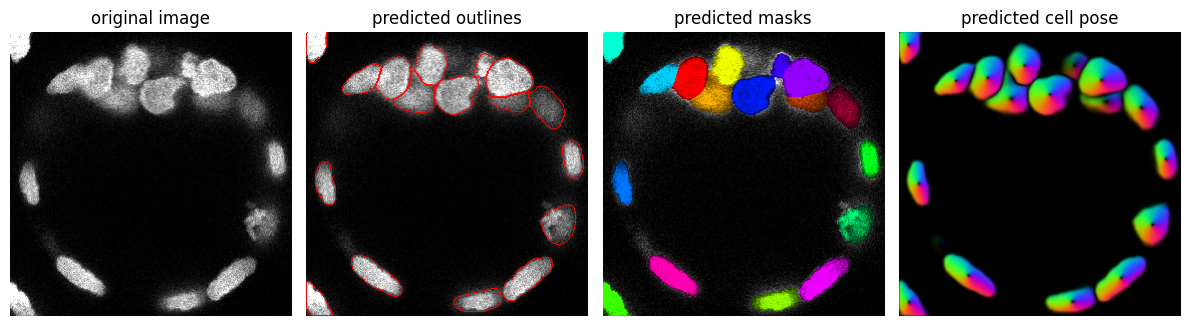

In [9]:
from cellpose import plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, data[t, 1, z, :, :], cellpose_masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()

## Save the Cellpose outlines

Convert the Cellpose outlines into OME ROI.

In [10]:
from cellpose import io, utils
outlines = utils.outlines_list(cellpose_masks)
io.outlines_to_text(str(image_id), outlines)

In [11]:
def create_roi(img, shapes):
    # create an ROI, link it to Image
    roi = omero.model.RoiI()
    # use the omero.model.ImageI that underlies the 'image' wrapper
    roi.setImage(img._obj)
    for shape in shapes:
        roi.addShape(shape)
    return roi

In [12]:
# Convert roi into ome rois
import re
import omero
from omero.rtypes import rdouble, rint, rstring
polygons = []
with open(str(image_id) + "_cp_outlines.txt", "r") as text_file:
    for line in text_file:
        points = re.sub(r',([^,]*),', r',\1, ', line)
        polygon = omero.model.PolygonI()
        polygon.theZ = rint(z)
        polygon.theT = rint(t)
        polygon.points = rstring(points)
        polygons.append(polygon)
roi = create_roi(image, polygons)

## Save the ROI

In [ ]:
conn.getUpdateService().saveAndReturnObject(roi)

### Close the connection  

In [14]:
conn.close()

### License (BSD 2-Clause)
Copyright (C) 2022-2024 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 